In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import tensorflow.keras.losses
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
dirr="C:/Users/Muhammed/Documents/Programlama/Yapay Zeka ve Uygulamaları/dataset/"
seed=38
batch_size=2

In [3]:
train_ds=tf.keras.utils.text_dataset_from_directory(
    directory=dirr,
    subset="training",
    validation_split=0.2,
    seed=seed,
    batch_size=batch_size
)

Found 35081 files belonging to 3 classes.
Using 28065 files for training.


In [10]:
val_ds = tf.keras.utils.text_dataset_from_directory(
    dirr, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 35081 files belonging to 3 classes.
Using 7016 files for validation.


In [11]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    "test",
    batch_size=batch_size)

Found 8769 files belonging to 3 classes.


In [4]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(#cumlelerin 250 boytlu vector'lere ceviren vectorize katmanı
    standardize=None,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [5]:
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
def vectorize_text(text,label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text),label

In [7]:
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [8]:
text_batch, label_batch = next(iter(train_ds))
text_batch, label_batch = next(iter(train_ds))
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'housegop talk offici offic deposit money akbank account dollar presid thank', shape=(), dtype=string)
Label Neutral
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,  241,  345, 1058,  353,  171,    4,  215, 1089,  973,  130,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   

In [9]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])#kelime havuzundaki 1287. kelime
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])#kelime havuzundaki 313. kelime
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  sad
 313 --->  iban
Vocabulary size: 10000


In [12]:
x_train_ds = train_ds.map(vectorize_text)
x_val_ds = val_ds.map(vectorize_text)
x_test_ds = test_ds.map(vectorize_text)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

x_train_ds = x_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
x_val_ds = x_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
x_test_ds = x_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
embedding_dim = 16

In [15]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
__________________________________________________

In [16]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
epochs = 10
history = model.fit(
    x_train_ds,
    validation_data=x_val_ds,
    epochs=epochs)

Epoch 1/10
14033/14033 [==============================] - 19s 1ms/step - loss: 0.8061 - accuracy: 0.6510 - val_loss: 0.6809 - val_accuracy: 0.7382
Epoch 2/10
14033/14033 [==============================] - 15s 1ms/step - loss: 0.6146 - accuracy: 0.7655 - val_loss: 0.5370 - val_accuracy: 0.7950
Epoch 3/10
14033/14033 [==============================] - 15s 1ms/step - loss: 0.4897 - accuracy: 0.8185 - val_loss: 0.4423 - val_accuracy: 0.8308
Epoch 4/10
14033/14033 [==============================] - 15s 1ms/step - loss: 0.4038 - accuracy: 0.8535 - val_loss: 0.3843 - val_accuracy: 0.8529
Epoch 5/10
14033/14033 [==============================] - 14s 1ms/step - loss: 0.3475 - accuracy: 0.8785 - val_loss: 0.3491 - val_accuracy: 0.8692
Epoch 6/10
14033/14033 [==============================] - 15s 1ms/step - loss: 0.3115 - accuracy: 0.8927 - val_loss: 0.3368 - val_accuracy: 0.8731
Epoch 7/10
14033/14033 [==============================] - 15s 1ms/step - loss: 0.2833 - accuracy: 0.9047 - val_loss: 0

In [18]:
loss, accuracy = model.evaluate(x_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

4385/4385 [==============================] - 5s 1ms/step - loss: 0.3088 - accuracy: 0.8929
Loss:  0.3088187873363495
Accuracy:  0.8929182291030884


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

C:\Users\Muhammed\AppData\Local\Temp\ipykernel_20940\4229359227.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss',color="orange")


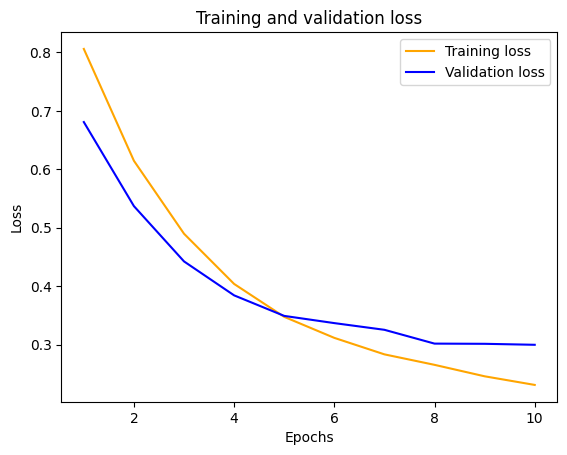

In [22]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss',color="orange")
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<h1>Modeli Kaydetme</h1>

In [40]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test_ds)
print(accuracy)

4385/4385 [==============================] - 3s 627us/step - loss: 0.2906 - accuracy: 0.9026
0.902611494064331


In [57]:
model.save('saved_model/my_model')
model.save_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [58]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.load_weights('./checkpoints/my_checkpoint')

In [61]:
loss, acc = model.evaluate(x_train_ds, verbose=2)

14033/14033 - 6s - loss: 0.1986 - accuracy: 0.9291 - 6s/epoch - 443us/step


In [62]:
model.save('my_model.h5')

In [63]:
new_model2 = tf.keras.models.load_model('my_model.h5')